## 3-2. QiskitとIBM Q Experienceの使い方
IBM Q Experienceは2016年5月24日にIBM社が世界で初めてクラウド上に公開した量子コンピュータである[[1]](https://quantumexperience.ng.bluemix.net/qx/experience)。この節では、IBM Q Experienceの使い方及びIBM社が開発している量子計算用フレームワーク[Qiskit](https://qiskit.org)の使い方を学ぶ。

### IBM Q Experienceの実行環境を用意する
#### アカウント登録
1. まず、IBM Q ExperienceのWebページ[[1]](https://quantumexperience.ng.bluemix.net/qx/experience) の右上のSign Inボタンをクリックしてアカウントを作る。
2. メールアドレスとパスワードもしくは外部サービスのアカウントが要求されるが、Sign Inボタン下のSign Upをクリックする。
3. 必要事項を記入し、Sign Upボタンをクリックする。
4. 登録したメールアドレスにメールが送られるので、そのメール内のリンクをクリックする。すると別ウィンドウで登録完了の画面が出るので、次からはログイン可能になる。

#### APIの取得
 これでIBM Q Experienceに登録できたので、次はIBM Q Experienceの実機(本物の量子コンピュータ)のアクセスに必要なIBM Q Experience APIの取得の仕方を学ぶ。

1. ログイン後にWelcome to Experience!のポップアップが出るので右上の×印をクリックして閉じる。
2. 画面右上のアイコン → “My Account”をクリックし、登録したアカウント情報を見る。
3. 画面右上に“Account”, “Community”, “Advanced”のうち“Advanced”をクリックする。
4. “API Token”の欄が“undefined”になっているので、“Regenerate”ボタンをクリックしてAPIを生成する。隣の“Copy this token”ボタンを押すとAPIをクリップボードに貼り付けられる。

ちなみに、IBM Q ExperienceのWebページ[[1]](https://quantumexperience.ng.bluemix.net/qx/experience)上のGUIでドラッグ＆ドロップで回路を生成して実行することや、Jupyter Notebook (Qiskit Notebooksと呼ばれている）をWebページ上で作成して実行することも可能である。

### Qiskitの実行環境を用意する
Qiskitはpipを経由してインストールすることができる。PC内のコマンドライン(Windowsのコマンドプロンプト、Macのターミナル)を使う場合はコマンドラインに`pip install qiskit`と入力して実行する。Jupyter NotebookまたはGoogle Colaboratoryをお使いの方は、以下のセルの`!pip install qiskit`を実行すると使えるようになる。

In [ ]:
!pip install qiskit

### Qiskitを使ってみる
QiskitはPythonフレームワークなので書く時の文法はPythonと同じである。その前に実機の使用に必要な情報をローカル環境に保存しておこう（このステップは各自の環境ごとに一回実行すれば良い）。

In [ ]:
## "MY_API_TOKEN" に、上で取得したtokenを入れる
from qiskit import IBMQ
IBMQ.save_account('MY_API_TOKEN')

ここでは、$|\Psi^{+}\rangle=\frac{|00\rangle + |11\rangle}{\sqrt{2}}$というBell状態ペアの生成のプログラムを例に学んでいく。

In [2]:
#必要なモジュールのインポート
from qiskit import IBMQ, QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, Aer
from qiskit.qasm import pi
from qiskit.tools.visualization import plot_histogram, circuit_drawer
import numpy as np

In [3]:
# 自分のアカウント情報をloadする。（あらかじめ IBMQ.save_account を実行しておく必要がある. 複数のアカウントを使い分ける時はここで行う)
provider = IBMQ.load_account()

# 自分のアカウントで使用できるバックエンドを見る
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>]

色々と出てきたが、`'ibmq_qasm_simulator'` (32量子ビットのシミュレータ)以外は5量子ビット・14量子ビットの実機の量子コンピュータである（IBM Q Experienceのログイン後の画面に詳細が載っている）。以下のコマンドを打つと1番空いていてジョブが投げやすい実機が分かる。

In [4]:
from qiskit.providers.ibmq import least_busy
backend_lb = least_busy(provider.backends(simulator=False, operational=True))
print("Least busy backend: ", backend_lb)

Least busy backend:  ibmqx2


`ibmqx2` が1番忙しくないことが分かったので、今回はそれを実機として使う。まずはシミュレータで量子回路を実行してみよう。

{'00': 2089, '11': 2007}


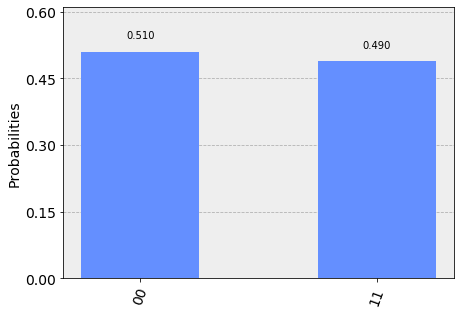

In [5]:
#量子レジスタqを生成する。
q = QuantumRegister(2)

#古典レジスタcを生成する
c = ClassicalRegister(2)

#量子レジスタqと古典レジスタc間で量子回路を生成する。
qc = QuantumCircuit(q, c)

#1番目の量子ビットにHゲートをかける。
qc.h(q[0])

#1-2番目の量子ビットにCNOTゲートをかける。(1番目の量子ビットが制御量子ビット、2番目の量子ビットがコントロール量子ビット)
qc.cx(q[0],q[1])

#1番目の量子ビットの測定値を1番目の古典ビットに、2番目の量子ビットの測定値を2番目の古典ビットに渡す。
qc.measure(q[0], c[0])
qc.measure(q[1], c[1])

#localのシミュレータとleast busyなbackend
backend_sim = Aer.get_backend("qasm_simulator")

#量子回路qcを指定したバックエンド(backend_sim)で4096回実行する。
result = execute(qc, backend_sim, shots=4096).result()

#結果を出力する。
print(result.get_counts(qc))

#結果のヒストグラムを描画する。
plot_histogram(result.get_counts(qc))

生成した状態は$\frac{|00\rangle + |11\rangle}{\sqrt{2}}$だから、式の通り$|00\rangle$、$|11\rangle$が得られる確率は共に50%に近いことが分かる。次に実機の結果を見てみよう。但し、実機での実験は結果を得るのに非常に時間がかかるので注意が必要だ。

{'00': 1844, '11': 2041, '01': 107, '10': 104}


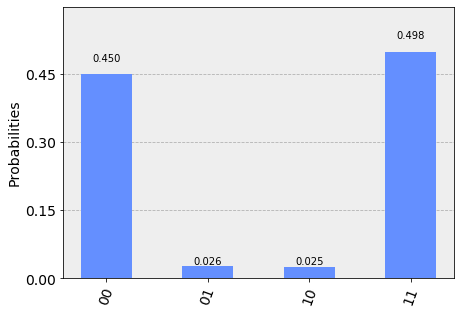

In [6]:
#least busyだったbackendを選ぶ
backend_sim = backend_lb

#量子回路qcを指定したバックエンド(backend_sim)で4096回実行する。
result = execute(qc, backend_sim, shots=4096).result()

#結果を出力する。
print(result.get_counts(qc))

#結果のヒストグラムを描画する。
plot_histogram(result.get_counts(qc))

実機による結果を見てみると、理論上は得られない$|01\rangle$と$|10\rangle$が得られていることが分かる。これは演算過程で生じたエラーによるものである。この結果は、今の量子コンピュータがNISQデバイス(中規模でノイズの発生を許す量子コンピュータ)と呼ばれることを分かりやすく示している。

### 参考文献 

[1] https://quantumexperience.ng.bluemix.net/qx/experience [online] (参照日時 2019-02-13)